# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
        
        if context is not None:
            if hasattr(self, 'n_dims'):
                if not context.shape == (self.n_arms*self.n_dims,):
                    raise TypeError("`context` must be a numeric array of length self.n_dims * self.n_arms")
            elif not context.size % self.n_arms == 0:
                    raise TypeError("Length of `context` is inconsistent with self.n_arms")


    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)
        
        if not (type(reward) ==  float or type(reward) == np.float64):
            raise TypeError("Reward` must be a float")
        if not arm > 0 and not arm <=self.n_arms:
            raise ValueError("Arm must be positive integer and may not be larger than self._narms")  
        
        if context is not None:
            if hasattr(self, 'n_dims'):
                if not context.shape == (self.n_arms*self.n_dims,):
                    raise TypeError("`context` must be a numeric array of length self.n_dims * self.n_arms")
            elif not context.size % self.n_arms == 0:
                    raise TypeError("Length of `context` is inconsistent with self.n_arms")

In [3]:
# Define global functions here, if required

def argmax_random_tie_breaking(data):
    # get the maximum value from the given array
    highest = max(data)

    # find keys corresponding to highest values and append them
    best_actions = [index for index, value in enumerate(data) if value == highest]

    # perform random tie breaking
    if len(best_actions)>1:
        action = np.random.choice(best_actions)
    else:
        action = best_actions[0]

    return action

## 1. Implement ε-greedy and UCB MABs

In [4]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        if not (type(epsilon) == float or type(epsilon) == np.float64):
            raise TypeError("`epsilon` must be a float")
        if not epsilon >= 0:
            raise ValueError("`epsilon` must be non-negative")
            
        super().__init__(n_arms)
        # your code here
        
        self.epsilon = epsilon
        
        # initialize values
        self.count_per_arm = [0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all the arms with zero total reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 

        
    def play(self, context=None):
        super().play(context)
        # your code here
        
        if np.random.random() < self.epsilon:
            # perform exploration action
            action = np.random.choice(self.q_values, 1)
        else:
            # perform exploitation action
            action = argmax_random_tie_breaking(self.q_values)
        return action
        
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        # your code here
                
        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        # update total reward
        self.total_reward_per_arm[arm] += reward
        
        # update q-valuesfor  each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
        
        return

In [5]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        if not (type(rho) == float or type(rho) == np.float64):
            raise TypeError("`rho` must be a float")
        if not rho > 0:
            raise ValueError("`rho` must be strictly positive")
        if not np.isreal(rho):
            raise ValueError("`rho` must be a real number")
        
        super().__init__(n_arms)
        # your code here

        # set rho
        self.rho = rho
        
        # Initialize step count for each arm
        self.count_per_arm = [0 for arm in range(n_arms)]
        
        # Initialize number of rounds played
        self.total_rounds = 0
        
        # Mean reward for each arm initialized with Q0
        self.q_values = [Q0 for arm in range(n_arms)]
        
        # Initialize all arms with zero reward
        self.total_reward_per_arm = [0 for arm in range(n_arms)] 
    
    
    def play(self, context=None):
        super().play(context)
        # your code here
        
        # copy reward for each arm for later calculation
        previous_values = self.q_values
        
        for arm in range(self.n_arms):
            if self.count_per_arm[arm] == 0:
                 # Use intial values for the first round
                continue            
            else:
                # Calculate updated q-value with exlpore boost for each arm
                exploration_hyperparameter = self.rho * np.log(self.total_rounds) / self.count_per_arm[arm]
                previous_values[arm] = previous_values[arm] + np.sqrt(exploration_hyperparameter)
            
        # Get the best action for given data
        action = argmax_random_tie_breaking(previous_values)
        return action
        
    def update(self, arm, reward, context=None):     
        super().update(arm, reward, context)
        # your code here

        # update the step of individual arms
        self.count_per_arm[arm] += 1
        
        # update the number of rounds played                                                                                               
        self.total_rounds += 1
        
        # update total reward per arm
        self.total_reward_per_arm[arm] += reward
        
        # update q-values each arm
        updated_reward =  self.total_reward_per_arm[arm] / self.count_per_arm[arm]
        self.q_values[arm] = updated_reward
                                                                                                       
        return

## 2. Implement off-policy evaluation

In [28]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    if not isinstance(mab, MAB):
        raise TypeError("'mab' must be an instance of MAB")
    if not np.issubdtype(arms.dtype, np.integer) and not arms.ndim == 1:
        raise TypeError("'arms' must be a 1-dimensional integer array")
    if not np.issubdtype(rewards.dtype, np.float64) and not rewards.ndim == 1:
        raise TypeError("`Rewards` must be a 1-dimensional float array")
    if not np.issubdtype(contexts.dtype, np.float64) and not contexts.ndim == 2:
        raise TypeError("`Contexts` must be a 2-dimensional float array")
    if not n_rounds > 0 or n_rounds is None:
        raise ValueError("n_rounds must be positive integer or None")
    
    # Initialize list to record  history
    history = [] 
    # Initialize list to record the total payoffs
    total_payoffs = []
    
    for event in range(len(arms)):
        # Stop if naximum nuber of rounds has been reached
        if len(history) == n_rounds:     
            break
            
        #Play an arm
        action = mab.play(contexts[event])
        
        #If the chosen action is present in the dataset
        if action == arms[event]:            
            history.append(event)
            total_payoffs.append(rewards[event])
            mab.update(arms[event],rewards[event],contexts[event])
    
    return total_payoffs

In [29]:
# load dataset here

list_of_arms = []
list_of_rewards = []
list_of_features = []

event_count = 0

# Read dataset and store arm, reward and context data into individual lists
with open("dataset.txt","r") as f:
    dataset = f.readlines()
    
for line in dataset:
    event_count += 1
    current_line = line.split()
    
    # get arm from dataset
    arm = int(current_line[0])
    
    # get reward from dataset
    reward = float(current_line[1])
    
    # get features from dataset and convert to float
    features = current_line[2:]
    features = [float(element) for element in features]
    
    list_of_arms.append(arm)
    list_of_rewards.append(reward)
    list_of_features.append(features)
    
#Convert lists into np_array
arms = np.array(list_of_arms)
rewards = np.array(list_of_rewards)
features = np.array(list_of_features)

# Reshape the context of each event into (10*10) array (10 arms w/ 10 features each)
contexts = features.reshape(event_count,(10*10))

In [32]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.155


In [33]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.09875


## 3. Implement LinUCB contextual MAB

In [47]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms)
        # your code here
        
        if not (type(alpha) == float or type(alpha) == np.float64):
            raise TypeError("`alpha` must be a float")
        if not alpha > 0.0 :
            raise ValueError("`alpha` must be strictly positive")
        if not np.isreal(alpha):
            raise ValueError("`alpha` must be a real number")
        if not n_dims > 0:
            raise ValueError("`n_dims` must be strictly positive")    
        
        # Initialize number of context features
        self.n_dims = n_dims
        
        # Initialize explore-exploit parameter
        self.alpha = alpha
        
        # Initialize list of d-dimensional identity matrices for each arm
        self.A_a = [np.identity(n_dims) for arm in range(n_arms)]
        
        # Initialize d-dimensional reward list
        self.b_a = [np.zeros(n_dims) for arm in range(n_arms)]


    def play(self, context):
        super().play(context)
        # your code here 

        posterior_probabilities = [0.0 for arm in range(self.n_arms)]
        
        context = context.reshape(self.n_arms, self.n_dims)
        
        for arm in range(0,self.n_arms):
            # Calculate updated theta parameter
            theta = np.dot(np.linalg.inv(self.A_a[arm]), self.b_a[arm])
            # Calculates variance
            variance = np.linalg.multi_dot([np.transpose(context[arm]), np.linalg.inv(self.A_a[arm]), context[arm]])
            # Calculate estimates of the posterior distribution
            p_ta = np.dot(theta.T,context[arm]) + self.alpha * np.sqrt(variance)
            # Update posterior probabilities
            posterior_probabilities[arm] = p_ta
            
        # Get the highest value from posterior distribution, then find the corresponding key and append them
        action = argmax_random_tie_breaking(posterior_probabilities)
        return action
        
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here

        context = context.reshape(self.n_arms,self.n_dims)

        # pass the arm-specific context (x_t,a)        
        x_t = context[arm].reshape(-1,1)
        x_t_x_t = np.dot(x_t,x_t.T)

        self.A_a[arm] = np.add(self.A_a[arm], x_t_x_t)
        self.b_a[arm] = np.add(self.b_a[arm], np.dot(reward,context[arm]))

In [48]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [36]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        # your code here
        
        if not n_dims > 0:
            raise ValueError("`n_dims` must be strictly positive")
            
        # Initialize number of context features
        self.n_dims = n_dims
        
        # Store decision tree classifier
        self.tree = tree
        
        # Initialize number of rounds played
        self.total_rounds = 0
        
        # Initialize historic (context, reward) pairs
        self.D_t_a = [[] for arm in range(n_arms)]
        
        # Initialize array of decision trees
        self.my_decision_trees = {}
        
    def play(self, context):
        super().play(context)
        # your code here
        
        # get the flattened context and reshape it to an array of shape (n_arms,n_dims)        
        context = np.reshape(context, (self.n_arms, self.n_dims))

        self.my_decision_trees[self.total_rounds] = [clone(self.tree) for arm in range(self.n_arms)]              
        
        my_predictions = [0 for arm in range(self.n_arms)]

        for arm in range(self.n_arms):       
            if len(self.D_t_a[arm]) == 0:
                
                # set decision tree to predict 1 for any input      
                X = context[arm].reshape(1, -1)
                y = [1]                
                self.my_decision_trees[self.total_rounds][arm].fit(X=X, y=y)
            else: 
                
                #sampling |D_t,a| observations from D_t,a with replacement
                number_of_samples = len(self.D_t_a[i])
                
                # get indices of context-reward-pairs to sample
                indices_to_sample = np.random.randint(number_of_samples, size=number_of_samples)
                X = []
                y = []
                
                # Sample bootstrapped dataset D_t,a from D_t,a
                for index in indices_to_sample:
                    context_reward_pair = self.D_t_a[arm][index]                                          
                    X.append(context_reward_pair[0].reshape(1,-1).flatten())
                    y.append(context_reward_pair[1])

                # fit the decision tree
                self.my_decision_trees[self.total_rounds][i].fit(X, y)
                
            x_t = context[i].reshape(1,-1)
            my_predictions[i] = self.my_decision_trees[self.total_rounds][i].predict(x_t)[0]
        
        # Choose action at = arg maxa pˆ(θt,a, xt,a)
        action = argmax_random_tie_breaking(my_predictions)

        return action
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here

        context = context.reshape(self.n_arms,self.n_dims)
        
        # pass the arm-specific context (x_t,a)
        x_t = context[arm].reshape(-1,1)
                
        # if|D_t,at| == 0, we add fabricated prior data
        if len(self.D_t_a[arm]) == 0:
            # Update Dt,at with (xt,at , 0) and (xt,at , 1)
            self.D_t_a[arm].append((x_t, 0))
            self.D_t_a[arm].append((x_t, 1))
    
        # Update Dt,at with (x_t,at , r_t,at)
        self.D_t_a[arm].append((x_t, reward))
        
        self.total_rounds += 1

In [37]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.6475


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

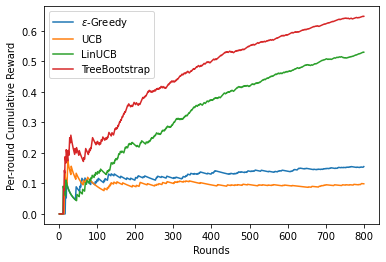

In [38]:
# your code here

rounds = np.linspace(1,len(results_EpsGreedy), len(results_EpsGreedy))

cumsum_EpsGreedy = np.cumsum(results_EpsGreedy)/ rounds
cumsum_UCB = np.cumsum(results_UCB)/ rounds
cumsum_LinUCB = np.cumsum(results_LinUCB)/ rounds
cumsum_TreeBootstrap = np.cumsum(results_TreeBootstrap)/ rounds

plt.plot(rounds, cumsum_EpsGreedy, label = r"$\epsilon$-Greedy")
plt.plot(rounds, cumsum_UCB, label = "UCB")
plt.plot(rounds, cumsum_LinUCB, label = "LinUCB")
plt.plot(rounds, cumsum_TreeBootstrap, label = "TreeBootstrap")
plt.ylabel('Per-round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()

### 5.B.

The maximum average reward is:  0.73125
Optimal alpha value to maximize reward:  0.02


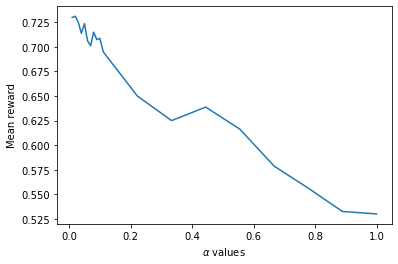

In [40]:
# your code here

#First Interval [0.1, 0.2, 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.] - zero removed
alpha_params_large_interval = np.linspace(0,1,10)[1:]

#Second Interval [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1] - zero removed
alpha_params_small_interval = np.linspace(0,0.1,11)[1:]

#Append two intervals and sort
alpha_grid_search_params = np.append(alpha_params_large_interval,alpha_params_small_interval) 
alpha_grid_search_params = np.sort(alpha_grid_search_params)

results_LinUCB_with_alpha_search = []
for alpha in alpha_grid_search_params:
    mab = LinUCB(10, 10, alpha)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_LinUCB_with_alpha_search.append(np.mean(results_LinUCB))

print("The maximum average reward is: ", np.max(results_LinUCB_with_alpha_search))
print("Optimal alpha value to maximize reward: ", alpha_grid_search_params[np.argmax(results_LinUCB_with_alpha_search)])
plt.plot(alpha_grid_search_params, results_LinUCB_with_alpha_search)
plt.ylabel('Mean reward')
plt.xlabel(r'$\alpha$ values')
plt.show()

## 6. Implement KernelUCB contextual MAB

In [41]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
        if not n_dims > 0:
            raise ValueError("`n_dims` must be strictly positive")          
        if not (type(gamma) == float or type(gamma) == np.float64):
            raise TypeError("`gamma` must be a float")
        if not gamma > 0:
            raise ValueError("`rho` must be strictly positive")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be a real number")
            
        if not (type(eta) == float or type(eta) == np.float64):
            raise TypeError("`eta` must be a float")
        if not eta > 0:
            raise ValueError("`eta` must be strictly positive")
        if not np.isreal(eta):
            raise ValueError("`eta` must be a real number")
            
        if not callable(kern): 
            raise TypeError("'kern' must be callable")
        
        # Initialize number of context features
        self.n_dims = n_dims
        # Initialize regularization parameter
        self.eta = eta
        # Initialize explore-exploit parameter
        self.gamma = gamma
        # Store kernel function
        self.kern = kern
        
        # Initialize number of rounds played
        self.total_rounds = 0
 
        # Initialize Kinv
        self.Kinv = np.empty(0, dtype=float)
        
        # Initialize reward history
        self.y_t = np.zeros(0, dtype=float)
        
        # Initialize context history
        self.a_t = np.zeros((0, n_dims), dtype=float)
        
        
    def play(self, context):
        super().play(context)
        # your code here
        
        
        # get the flattened context and reshape it to an array of shape (n_arms,n_dims)        
        #context = np.reshape(context, newshape=(self.n_arms, -1))
        context = np.reshape(context, (self.n_arms, self.n_dims))
        
        u = [0 for arm in range(self.n_arms)]
        
        # in initial round
        if self.total_rounds == 0:
            #  in initial round set u[0] to 1.0
            u[0] = 1.0
        else:
            kxx = self.kern(context).diagonal()
            kx = self.kern(context, self.a_t)

            for arm in range(self.n_arms):
                variance = kxx[arm] - kx[arm].T.dot(self.Kinv @ kx[arm].T)
                prediction = np.dot(kx[arm], self.Kinv @ self.y_t)
                u[arm] = prediction + self.eta/(np.sqrt(self.gamma)) * np.sqrt(variance)
            
        action = argmax_random_tie_breaking(u)
        return action
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here
        
        # reshape into shape (n_arms, n_dims)
        context = np.reshape(context, newshape=(self.n_arms, self.n_dims))
        
        # Reshape context and store context for action
        self.a_t = np.append(self.a_t, context[arm].reshape(1, -1), axis=0)
        # Update reward history
        self.y_t = np.append(self.y_t, reward)

        # kernel multiply current context and previous contexts
        kx = self.kern(context, self.a_t)
        
        if self.total_rounds == 0:
            # reshape kx[arm] into 2d array 
            self.Kinv = 1 / (kx[arm].reshape(1, -1) + self.gamma)        
        else:
            # b = (kx_1 kx_2 ... kx_t−1)
            b = kx[arm, :-1]
            b_Kinv = b @ self.Kinv
            Kinv_b = self.Kinv @ b
            
            # Get the last element in kx for current arm
            K22 = 1 / (kx[arm,-1] + self.gamma - np.dot(b, Kinv_b))
            # reshape K22 into correct matrix form
            K22 = K22.reshape(1, -1)
            
            Kinv_b_b_Kinv = Kinv_b[:,None]*b_Kinv[None,:]
            K11 = self.Kinv + K22 * Kinv_b_b_Kinv
            K12 = -K22 * Kinv_b.reshape(self.total_rounds, -1)
            K21 = -K22 * b_Kinv.reshape(1, self.total_rounds)
            
            self.Kinv = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22)))) 
        
        self.total_rounds += 1

In [42]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.72875


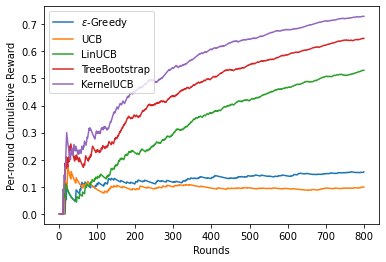

In [43]:
# your plotting code here

rounds = np.linspace(1,len(results_EpsGreedy), len(results_EpsGreedy))

cumsum_EpsGreedy = np.cumsum(results_EpsGreedy)/ rounds
cumsum_UCB = np.cumsum(results_UCB)/ rounds
cumsum_LinUCB = np.cumsum(results_LinUCB)/ rounds
cumsum_TreeBootstrap = np.cumsum(results_TreeBootstrap)/ rounds
cumsum_KernelUCB = np.cumsum(results_KernelUCB)/ rounds

plt.plot(rounds, cumsum_EpsGreedy, label = r"$\epsilon$-Greedy")
plt.plot(rounds, cumsum_UCB, label = "UCB")
plt.plot(rounds, cumsum_LinUCB, label = "LinUCB")
plt.plot(rounds, cumsum_TreeBootstrap, label = "TreeBootstrap")
plt.plot(rounds, cumsum_KernelUCB, label = "KernelUCB")
plt.ylabel('Per-round Cumulative Reward')
plt.xlabel('Rounds')
plt.legend()
plt.show()

In [ ]:
# Demonstrate a MAB hyperparameter setting using the RBF kernel

# gamma interval [0.5, 1.0 , 1.5, ...., 9.0, 9.5, 10] - zero removed
# gamma_grid_search_params = np.linspace(0, 10, 21)[1:]
gamma_grid_search_params = np.linspace(0, 0.1, 21)[1:]

results_KernelUCB_with_gamma_search = []

for my_gamma in range(len(gamma_grid_search_params)):
    # wrap rbf_kernel in custom function to set gamma parameter
    def rbf_kernel_wrapped_gamma(X, Y = None, gamma = my_gamma):
        return rbf_kernel(X, Y, gamma= gamma)
    
    mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel_wrapped_gamma)
    results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    results_KernelUCB_with_gamma_search.append(np.mean(results_KernelUCB))

print("The maximum average reward is: ", np.max(results_KernelUCB_with_gamma_search))
print("Optimal gamma value to maximize reward: ", gamma_grid_search_params[np.argmax(results_KernelUCB_with_gamma_search)])
plt.plot(gamma_grid_search_params, results_KernelUCB_with_gamma_search)
plt.ylabel('Mean reward')
plt.xlabel(r'$\gamma$ values')
plt.show()